In [2]:
from lottery import *

In [3]:
from threading import Thread


In [10]:
import os


# controller gains search space simulation.  

## simulation parameters

In [5]:
AVG_LEN = 3

KP_STEP=0.1
KP_SEARCH_START=-0.3
KP_SEARCH_END=0.3

KI_STEP=0.1
KI_SEARCH_START=-0.1
KI_SEARCH_END=0.1

KD_STEP=0.1
KD_SEARCH_START=-0.1
KD_SEARCH_END=0.1

EPSILON=0.0001
RUNNING_TIME=1000

#AIRDROP=1000
NODES=30

In [6]:
randomize_nodes_str = input("randomize number of nodes (y/n):")
randomize_nodes = True if randomize_nodes_str.lower()=="y" else False

rand_running_time_str = input("random running time (y/n):")
rand_running_time = True if rand_running_time_str.lower()=="y" else False

debug_str = input("debug mode (y/n):")
debug = True if debug_str.lower()=="y" else False

randomize number of nodes (y/n):5
random running time (y/n):1000
debug mode (y/n):y


In [7]:
def experiment(accs, controller=CONTROLLER_TYPE_DISCRETE, kp=0, ki=0, kd=0):
    dt = DarkfiTable(0, RUNNING_TIME)
    darkie_accs = []
    #sum_airdrops = 0
    # random nodes
    RND_NODES = random.randint(5, NODES) if randomize_nodes else NODES
    for idx in range(0,RND_NODES):
        # random airdrops
        #darkie_airdrop = None
        #if idx == RND_NODES-1:
            #darkie_airdrop = AIRDROP - sum_airdrops
        #else:
            #remaining_stake = (AIRDROP-RND_NODES)-sum_airdrops
            #if remaining_stake <= 1:
                #continue
            #darkie_airdrop = random.randrange(1, remaining_stake)
        #sum_airdrops += darkie_airdrop
        darkie = Darkie(controller, 0, kp=kp, ki=ki, kd=kd)
        dt.add_darkie(darkie)
        darkie_acc = dt.background(rand_running_time)
        darkie_accs+=[darkie_acc]
    acc = sum(darkie_accs)/(float(len(darkie_accs))+EPSILON)
    accs+=[acc]

## note! skip the cell below, it will take many hours, and large space dpending on the search space range above.

In [8]:
accuracy = []
if __name__ == "__main__":
    # kp
    for kp in tqdm(np.arange(KP_SEARCH_START, KP_SEARCH_END, KP_STEP)):
        # ki
        for ki in np.arange(KI_SEARCH_START, KI_SEARCH_END, KI_STEP):
            # kd
            for kd in np.arange(KD_SEARCH_START, KD_SEARCH_END, KD_STEP):
                target = 1
                experiment_accs = []
                exp_threads = []
                for i in range(0, AVG_LEN):
                    exp_thread = Thread(target=experiment, args=[experiment_accs, CONTROLLER_TYPE_DISCRETE, kp, ki, kd])
                    exp_thread.start()
                for thread in exp_threads:
                    thread.join()
                avg_acc = sum(experiment_accs)/float(AVG_LEN)
                gains = (avg_acc, (kp, ki, kd))
                accuracy+=[gains]
    accuracy=sorted(accuracy, key=lambda i: i[0], reverse=True)
    with open("gains.txt", "w") as f:
        buff=''
        for gain in accuracy:
            line=str(gain[0])+',' +','.join([str(i) for i in gain[1]])+'\n'
            buff+=line
            f.write(buff)


100%|██████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 40.77it/s]


# controller parameters results


the controller results shows that optimal gains are as follows:
kp=0.18, ki=0.02, kd=-0.1,

# run lottery instance

In [31]:
def instance(kp, ki, kd, nodes, initial_distribution):
    os.system("rm f[0-9]*; rm leads[0-9]*; rm f.hist; rm leads.hist")
    RUNNING_TIME = int(input("running time (slots):"))

    if __name__ == "__main__":
        darkies = []
        darkies += [Darkie(CONTROLLER_TYPE_DISCRETE, int(initial_distribution[id]), id=id+len(darkies), kp=kp, ki=ki, kd=kd) for id in range(nodes)]
        airdrop = 0
        for darkie in darkies:
            airdrop+=darkie.stake
        print("network airdrop: {} on {} nodes".format(airdrop, len(darkies)))
        dt = DarkfiTable(airdrop, RUNNING_TIME)
        for darkie in darkies:
            dt.add_darkie(darkie)
        dt.background(rand_running_time=False)
        dt.write()


In [32]:
def draw():
    os.system("cat f0* > f.hist")
    os.system("cat leads0* > leads.hist")

    LEAD_FILE = "leads.hist"
    F_FILE = "f.hist"

    LEAD_PROCESSED_IMG = "lead_history_processed.png"
    F_PROCESSED_IMG = "f_history_processed.png"

    SEP = ","
    NODES = 5 # nuber of nodes logged

    with open(LEAD_FILE) as f:
        buf = f.read()
        nodes = buf.split(SEP)[:-1]
        node_log = []
        for i in range(0, len(nodes)):
            node_log+=[int(nodes[i])]
        freq_single_lead = sum(np.array(node_log)==1)/float(len(node_log))
        print("single leader frequency: {}".format(freq_single_lead))
        plt.plot(node_log)
        plt.legend(['#leads'])
        plt.savefig(LEAD_PROCESSED_IMG)


    with open(F_FILE) as f:
        buf = f.read()
        nodes = buf.split(SEP)[:-1]
        node_log = []
        for i in range(0, len(nodes)):
            node_log+=[float(nodes[i])]
        plt.plot(node_log)
        plt.legend(['#leads', 'f'])
        plt.savefig(F_PROCESSED_IMG)

running time (slots):1000
network airdrop: 0 on 8 nodes
single leader frequency: 0.4301397205588822


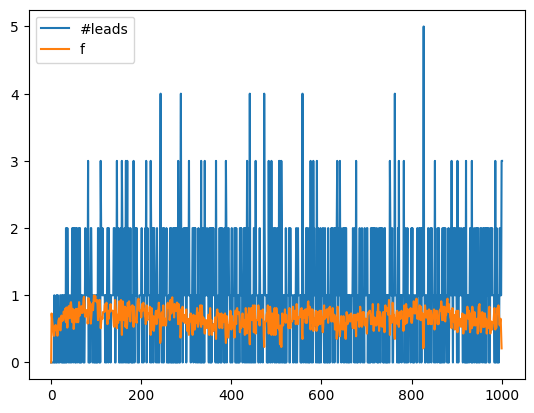

In [34]:
nodes = random.randint(3,10) 
# stakers intial distribution
genesis_distribution = [0 for _ in range(nodes)]
# using simulation output
kp=0.18
ki=0.02
kd=-0.1
instance(kp, ki, kd, nodes, genesis_distribution)
draw()